In [2]:
from google.colab import drive
import os
from PIL import Image, ImageDraw, ImageFont,ImageOps
from PIL.Image import open
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import warnings
warnings.filterwarnings('ignore')

In [6]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [7]:
path_to_zip = '/content/drive/My\ Drive/fast_ai/datasets/Images.tar.xz'

In [8]:
! tar -xf {path_to_zip}

In [9]:
import cv2
from google.colab.patches import cv2_imshow

In [10]:
lists = os.listdir('/content/Images/')
lists[:10]

['2313122.png',
 '208014.png',
 '1006102.png',
 '2870114.png',
 '2352113.png',
 '2964081.png',
 '2115081.png',
 '2124011.png',
 '2728114.png',
 '2358094.png']

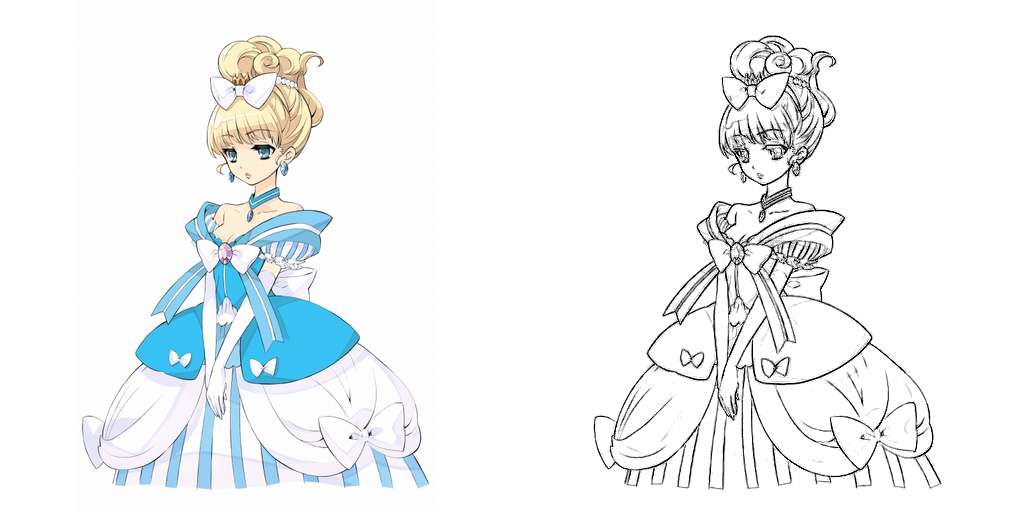

In [25]:
image = cv2.imread('/content/Images/'+'1846102.png')
cv2_imshow(image)
#print (image is not None)

In [12]:
height, width = image.shape[:2]
height, width

(512, 1024)

In [13]:
start_row, start_col = int(0), int(0)
# Let's get the ending pixel coordinates (bottom right of cropped top)
end_row, end_col = int(height), int(width* .5)
cropped_left = image[start_row:end_row , start_col:end_col]

In [14]:
print (start_row, end_row) 
print (start_col, end_col)

0 512
0 512


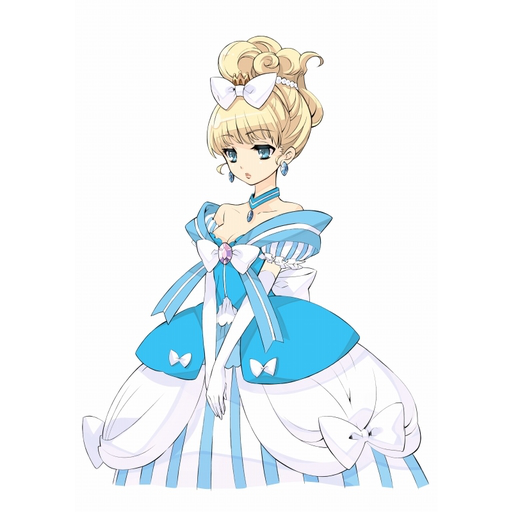

In [15]:
cv2_imshow(cropped_left)

In [16]:
start_row, start_col = int(0), int(width * .5)
# Let's get the ending pixel coordinates (bottom right of cropped bottom)
end_row, end_col = int(height), int(width)
cropped_bot = image[start_row:end_row , start_col:end_col]
print (start_row, end_row )
print (start_col, end_col)

0 512
512 1024


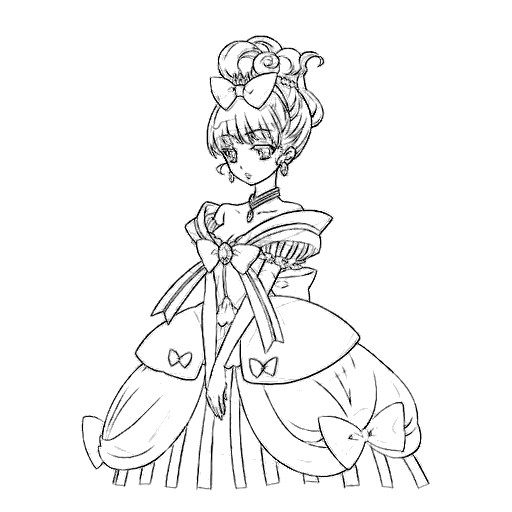

In [17]:
cv2_imshow(cropped_bot)

In [64]:
path_color = '/content/color'
path_sketch = '/content/sketch/'
os.mkdir(path_color)
os.mkdir(path_sketch)

In [26]:
def separator(images):
  for i in images:
    # print ('/content/Images/'+i)
    img = cv2.imread('/content/Images/'+i)
    if img is not None:
      height, width = img.shape[:2]
      # left colored part
      start_row, start_col = int(0), int(0)
      end_row, end_col = int(height), int(width* .5)
      cropped_left = image[start_row:end_row , start_col:end_col]
      cv2.imwrite(path_color+'/'+i, cropped_left)
      #right sketch part
      start_row, start_col = int(0), int(width * .5)
      end_row, end_col = int(height), int(width)
      cropped_right = image[start_row:end_row , start_col:end_col]
      cv2.imwrite(path_sketch+'/'+i, cropped_right)

In [27]:
separator(lists)

In [62]:
color = os.listdir(path_color)
sketch = os.listdir(path_sketch)
os.mkdir('/content/gray/')

In [65]:
path_gray = '/content/gray'

In [66]:
class crappifier(object):
    def __init__(self, path_gray, path_color):
        self.path_gray = path_gray
        self.path_color = path_color              
        
    def __call__(self, fn, i):       
        dest = self.path_gray/fn.relative_to(self.path_color)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        img = ImageOps.grayscale(img)
        img.save(dest)

In [67]:
il = ImageList.from_folder(path_color)

In [68]:
parallel(crappifier(path_gray, path_color), il.items)

In [69]:
bs, size = 64, 160
arch = models.resnet34

In [70]:
src = ImageList.from_folder(path_gray).split_by_rand_pct(0.1, seed=42)

In [76]:
def get_data(bs, size):
  data = (src.label_from_func(lambda x: path_color+'/'+x.name)
  .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
  .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

  data.c = 3
  return data